Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_89 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_90 (Conv2D)          (None, 128, 128, 8)       2312      
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 64, 64, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 64, 64, 8)         584       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 32, 32, 8)      

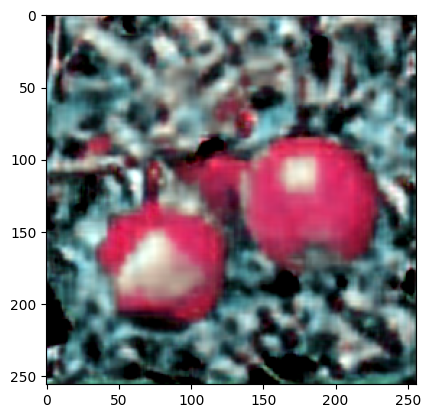

In [ ]:
from matplotlib.pyplot import imshow
import numpy as np
import cv2
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential


# SIZE=img.shape  #Limiting to 256 size image as my laptop cannot handle larger images. 
img_data=[]
SIZE=256
img=cv2.imread('/content/drive/MyDrive/images/train_histogram_equalisation/apple_13.jpg', 1)
   #Change 1 to 0 for Grey scale images
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #Changing BGR to RGB to show images in true colors
img=cv2.resize(img,(SIZE, SIZE))
img_data.append(img_to_array(img))
img_data


img_array = np.reshape(img_data, (len(img_data),SIZE, SIZE, 3))
img_array = img_array.astype('float32') / 255.


img_data2=[]  #Second image to be provided as ground truth. 

# img2=cv2.imread('images/einstein_mona_lisa/monalisa_original.jpg', 1)   #Change 1 to 0 for Grey scale images
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)#Changing BGR to RGB to show images in true colors
# img2=cv2.resize(img2,(SIZE, SIZE))
# img_data2.append(img_to_array(img2))

# img_array2 = np.reshape(img_data2, (len(img_data2), SIZE, SIZE, 3))
# img_array2 = img_array2.astype('float32') / 255.

# Define Autoencoder model. 

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
 

model.add(MaxPooling2D((2, 2), padding='same'))
     
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

model.fit(img_array, img_array,
        epochs=1000,                  #1000s of epochs needed for good results. Use GPU.
        shuffle=True)           #Shuffle data for each epoch


print("Output")
pred = model.predict(img_array)   #Predict model on the same input array.

#In reality, train on 1000s of input images and predict on images that the training 
#algorithm never saw. 

imshow(pred[0].reshape(SIZE,SIZE,3), cmap="gray")

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate

#Convolutional block to be used in autoencoder and U-Net
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block for autoencoder (no skip connections)
def decoder_block(input, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = conv_block(x, num_filters)
    return x

#Encoder will be the same for Autoencoder and U-net
#We are getting both conv output and maxpool output for convenience.
#we will ignore conv output for Autoencoder. It acts as skip connections for U-Net
def build_encoder(input_image):
    #inputs = Input(input_shape)

    s1, p1 = encoder_block(input_image, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    
    encoded = conv_block(p4, 1024) #Bridge
    
    return encoded

#Decoder for Autoencoder ONLY. 
def build_decoder(encoded):
    d1 = decoder_block(encoded, 512)
    d2 = decoder_block(d1, 256)
    d3 = decoder_block(d2, 128)
    d4 = decoder_block(d3, 64)
    
    decoded = Conv2D(3, 3, padding="same", activation="sigmoid")(d4)
    return decoded

#Use encoder and decoder blocks to build the autoencoder. 
def build_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    autoencoder = Model(input_img, build_decoder(build_encoder(input_img)))
    return(autoencoder)

# model=build_autoencoder((256, 256, 3))
# print(model.summary())

#Decoder block for unet
#skip features gets input from encoder for concatenation
def decoder_block_for_unet(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block_for_unet(b1, s4, 512)
    d2 = decoder_block_for_unet(d1, s3, 256)
    d3 = decoder_block_for_unet(d2, s2, 128)
    d4 = decoder_block_for_unet(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

    model = Model(inputs, outputs, name="U-Net")
    print(model.summary())
    return model


In [ ]:
from matplotlib.pyplot import imshow
import numpy as np
import cv2
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential


# SIZE=img.shape  #Limiting to 256 size image as my laptop cannot handle larger images. 
img_data=[]
SIZE=256
img=cv2.imread('/content/drive/MyDrive/images/train_histogram_equalisation/apple_12.jpg', 1)
   #Change 1 to 0 for Grey scale images
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  #Changing BGR to RGB to show images in true colors
img=cv2.resize(img,(SIZE, SIZE))
img_data.append(img_to_array(img))
img_data


img_array = np.reshape(img_data, (len(img_data),SIZE, SIZE, 3))
img_array = img_array.astype('float32') / 255.
model=build_autoencoder(img.shape)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
print(model.summary())

model.fit(img_array, img_array,
        epochs=1000,                  #1000s of epochs needed for good results. Use GPU.
        shuffle=True)           #Shuffle data for each epoch


print("Output")
pred = model.predict(img_array)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_96 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization_18 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 256, 256, 64)      0         
                                                                 
 conv2d_97 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_19 (Bat  (None, 256, 256, 64)     256       
 chNormalization)                                          

In [ ]:
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original image')
plt.subplot(1,2,2)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.title('reconstructed')
plt.show()

In [ ]:
sudo pip install keras

SyntaxError: ignored

In [ ]:
!pip install matplotlib-venn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate
